In [1]:
using DrWatson;
@quickactivate "MATH361Lectures"
using LinearAlgebra, DataFrames, Plots;
import MATH361Lectures;

# Efficieny of Matrix Computations

In this lecture, we will consider the efficiency of matrix computations such as forward and back substitution, and LU factorization. The lecture video on [operation counts](https://www.youtube.com/watch?v=FGfDHLpfkZo&list=PLvUvOH0OYx3BcZivtXMIwP6hKoYv0YvGn&index=9) compliments these notes. 

It is not really practical to try to predict exactly how long it will take a particular algorithm to solve a given problem even though this would be nice to know. On the other hand, it is fairly straightforward to obtain a good estimate of how the work required by an algorithm scales with the size of the problem. It should seem intuitively obvious that a larger linear system will require more work to solve than a smaller one will. Furthermore, you would probably guess that the amount of work will increase in a systematic way as the size of the problem increases.  

The way that numerical analysts and computer scientists typically measure the work required to run a numerical algorithm is by counting the number of floating point operations ([FLOP](https://en.wikipedia.org/wiki/FLOPS)) required to compute with the algorithm. If you know about how long it takes to perform a floating point operation, then you can also compute the number of floating point operations per second (FLOPS).   

## Asymptotic Estimation

For two functions $f$ and $g$, we say that $f$ is "[big-O](https://en.wikipedia.org/wiki/Big_O_notation)" of $g$, and write $f = \mathcal{O}(g)$,  if there exists a constant $C$ and an input value $x_{0}$ such $|f(x)| \leq C|g(x)|$ for all $x\geq x_{0}$. Notice that if $f = \mathcal{O}(g)$, then 

$\lim_{x\rightarrow \infty}\frac{|f(x)|}{|g(x)|} \leq C$. 

Likewise, if there is a positive constant $C$ such that 

$\lim_{x\rightarrow \infty}\frac{|f(x)|}{|g(x)|} = C$,

then we must have that $f = \mathcal{O}(g)$.

Furthermore, we say that a function $f$ is **asymptotic** to a function $g$, and write $f \sim g$, if 

$\lim_{x\rightarrow \infty}\frac{|f(x)|}{|g(x)|} = 1$.

Obviously $f \sim g$ imples $f = \mathcal{O}(g)$ but not necessarily the other way around.  

**Example:**

Let $f(x) = 3x^2 + 2x + 8$, and let $g(x) = 6x^2$. We have that 

$\lim_{x \rightarrow \infty}\frac{f(x)}{g(x)} = \lim_{x \rightarrow \infty}\frac{3x^2 + 2x + 8}{6x^2} = \lim_{x \rightarrow \infty}\frac{1 + \frac{2}{3x} + \frac{8}{3x^2}}{2} = \frac{1}{2}$,

so $f=\mathcal{O}(g)$. 

More generally, if $f(x) = a_{n}x^{n}+a_{n-1}x^{n-1}+\cdots +a_{1}x+a_{0}$ and $g=b_{n}x^{n}$ where both $a_{n}$ and $b_{n}$ are positive then $f=\mathcal{O}(g)$ and $f\sim g$ if and only if $\frac{a_{n}}{b_{n}}=1$. 

One can also derive that if $f(x) = \sin\left(\frac{1}{x}\right)$, $g(x) = \frac{1}{x}$, and $h(x) = \frac{1}{x^2}$, then $f\sim g$ but $f \neq \mathcal{O}(h)$.

## FLOP Counts

When we compute, a single instance of any of the addition, subtraction, multiplication, or division of two numbers is considered one floating point operation (FLOP). In numerical linear algebra, one uses FLOP counts to assess the "cost" of the algorithm. Let's look at a very simple example.  

Suppose that we want to compute the dot product of two vectors $x = \left[\begin{array}{cccc} x_{1} & x_{2} & \cdots & x_{n}  \end{array}\right]^T$ and $y = \left[\begin{array}{cccc} y_{1} & y_{2} & \cdots & y_{n}  \end{array}\right]^T$, recall this is defined to be

$x\cdot y = x_{1}y_{1} + x_{2}y_{2} + \cdots + x_{n}y_{n} = \sum_{i=1}^{n}x_{i}y_{i}$.

In terms of the  of **mathematical** operations in the definition of the dot product, there are $n$ multiplications and $n-1$ additions for a total of $n + (n-1) = 2n-1$ operations. It is important to realize however that a numerical algorithm might perform a different number of floating point operations than appear in an abstract mathematical definition. For example, the next function named `mydotproduct` implements a computer algorithm for computing the dot product. 

In [2]:
function mydotproduct(x,y)
    n = length(x);
    z = 0.0;
    for i=1:n # loop n times
        z = z + x[i]*y[i]; # 1 addition + 1 multiplication = 2 operations
    end 
    return z
end

mydotproduct (generic function with 1 method)

In [3]:
# An example use of mydotproduct
x = [1.0,1.0,2.0];
y = [-1.0,2.0,3.0];
z = mydotproduct(x,y)

7.0

Compare this last result with what we get when we use the `dot` function in Julia.

In [4]:
dot(x,y)

7.0

Each time through the loop we carry out two floating point operations and we go through the loop $n$ times for a total of $2n$ FLOPs. **Note:** the extra operation really comes from the need to store the result. Furthermore, since the first time through the loop we are really adding zero we could ignore the initial addition. However, the result produces the same asymptotic estimate since both $2n$ and $2n-1$ are $\mathcal{O}(n)$.  

In Julia, we can use the `@elapsed` macro to see how long it takes for a program to run. Let's compute this time for the dot product algorithm for several different sizes of vectors. 

In [5]:
vect_sizes = 400:400:16000;
dps = [@elapsed mydotproduct(randn(n),randn(n)) for n in vect_sizes];
results = DataFrame(size=vect_sizes,time=dps);
first(results,10)

,size,time
,Int64,Float64
1,400,1.63e-5
2,800,4.1e-5
3,1200,8.7e-6
4,1600,9.3e-6
5,2000,1.28e-5
6,2400,1.31e-5
7,2800,1.42e-5
8,3200,1.59e-5
9,3600,1.9e-5


In [6]:
last(results,10)

,size,time
,Int64,Float64
1,12400,9.27e-5
2,12800,7.81e-5
3,13200,6.94e-5
4,13600,6.5e-5
5,14000,0.0001635
6,14400,0.0001165
7,14800,0.0001648
8,15200,0.0001277
9,15600,0.0001156


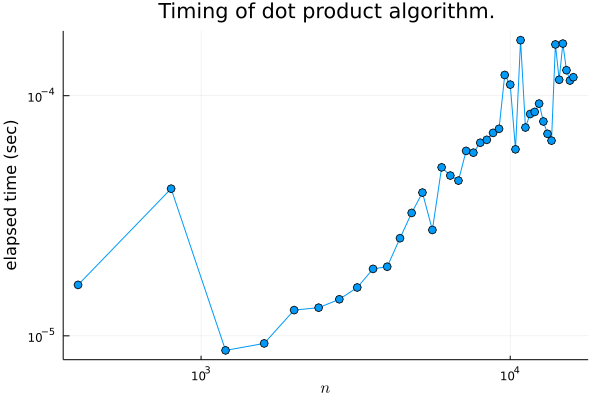

In [7]:
plot(vect_sizes,dps,m=:o,
    xaxis=(:log10,"\$n\$"),yaxis=(:log10,"elapsed time (sec)"),
    title="Timing of dot product algorithm.",label="data",leg=false)

Note that this is a log-log plot! Why do we use a log-log plot? Let's think about this for a moment. Suppose that the scaling is given by a **power law**, that is, suppose that $f(n) = Cn^p$ tells us how the amount of work required scales with the size of the problem. Then if we take the $\log$ of both sides we have that 

$\log(f(n)) = \log(Cn^p) = \log(C) + p\log(n)$. 

In this last equation, we see that $\log(f(n))$ is a linear function of $\log(n)$ and the slope of the linear equation is the exponent $p$. 

Furthermore, choose any fixed value $n_{0}$, then we have that 

$\frac{f(n)}{f(n_{0})} = \frac{Cn^p}{Cn_{0}^{p}} = \left(\frac{n}{n_0}\right)^p$

and thus, $f(n) = f(n_{0})\left(\frac{n}{n_0}\right)^p$. 

Let's add the line that corresponds to the $\log$ of both sides of the last equation to our previous plot.

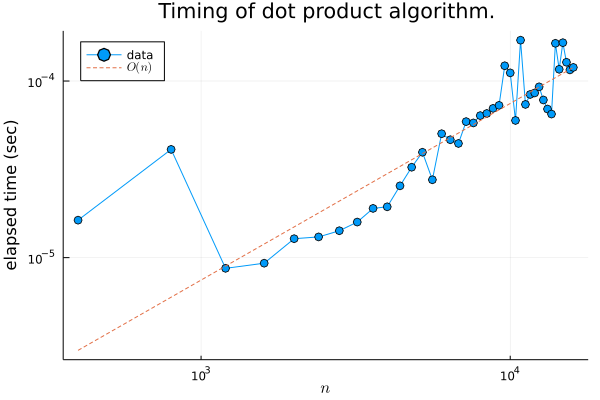

In [8]:
plot!(vect_sizes,(vect_sizes/vect_sizes[end])*dps[end],l=:dash,
    label="\$O(n)\$",legend=:topleft)

This provides an experimental confirmation that the dot product algorithm scales as $\mathcal{O}(n)$.  

### An Extension

There are two common ways to view matrix multiplication:

1) As a series of dot products.

2) As linear combinations of vectors. 

Both points of view have their usefulness. For now, let's make use of the first perspective.  

Recall that if $A$ is an $m\times n$ matrix and $x$ is an $n \times 1$ column vector then the product $Ax$ is an $m \times 1$ column vector $y$, where $y_{i} = \text{dot product of row $i$ of $A$ with $x$}$. This implies that we can build an algorithm for matrix vector multiplication out of our algorithm for the dot product. (You will be asked to implement such an algorithm for homework.) All we have to do is to apply our dot product algorithm for each row of the matrix, Then the number of FLOPs will be  $m(2n)=2mn$. 

Pushing this further, it is the case that matrix-matrix multiplication is a series of dot products in that if $A$ is $m\times n$ and $B$ is $n\times p$, then $AB$ is $m \times p$ and the $ij$ entry of $AB$ is the dot product between row $i$ of $A$ and column $j$ of $B$. So essentially, we are performing $n$ matrix vector multiplications or equivalently $mn$ dot products, either way we have a total of $2mn^2$ FLOPs. If we are working with only square matrices, then we see that there will be $2n^3$ FLOPs so we expect that multiplication of square matrices will scale as $\mathcal{O}(n^3)$. We can confirm this experimentally similarly to the way we did with the dot product. 

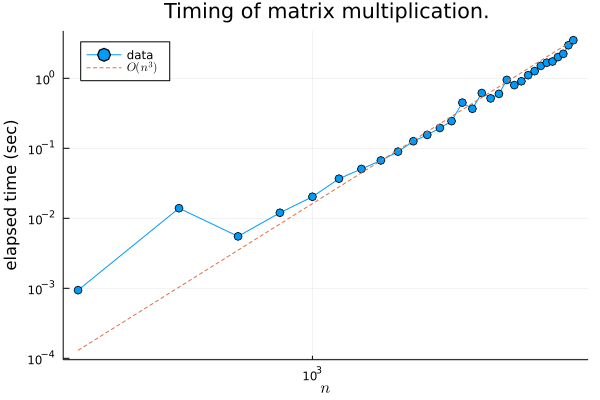

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\R01235571\.julia\packages\PlotUtils\n4I4Q\src\ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\R01235571\.julia\packages\PlotUtils\n4I4Q\src\ticks.jl:295


In [9]:
mat_sizes = 200:200:6000;
mps = [@elapsed randn(n,n)*randn(n,n) for n in mat_sizes];
plot(mat_sizes,mps,m=:o,
    xaxis=(:log10,"\$n\$"),yaxis=(:log10,"elapsed time (sec)"),
    title="Timing of matrix multiplication.",label="data",leg=false)
plot!(mat_sizes,mps[end].*(mat_sizes/mat_sizes[end]).^3,l=:dash,
    label="\$O(n^3)\$",legend=:topleft)

The previous plot provides experimental evidence that matrix multiplication is $\mathcal{O}(n^3)$.

## FLOP Counts for Solving Linear Systems

We will now examine the FLOP counts for back and forward substitution and LU factorization. We state the results in this notebook and derive them on the board. A very helpful fact that is worth remebering is that

$\sum_{k=1}^{n}k^p \sim \frac{n^{p+1}}{p+1} = \mathcal{O}(n^{p+1}),\ \text{as}\  n\rightarrow \infty$.

This says that when you add up consecutively the $p$-th powers of the first $n$ positive integers, the result is $\mathcal{O}(n^{p+1})$. (This formula should remind you of the antiderivative for power functions.)

**Result:**

1) Back and forward substitution are each $\sim n^2$ FLOPs.

2) LU factorization is asymptotic with $\frac{2}{3}n^3$.

3) The cost of solving a system of linear equations using LU factorization together with back and forward substitution is $\mathcal{O}(n^3)$. (This follows from points 1 and 2.)

4) The cost to invert a square matrix is asymptotic with $\frac{8}{3}n^3$. (This is a homework problem.)

## Pivoting

As we have presented LU factorization, there is a stability issue. We will demonstrate this by way of an example. 

In [10]:
A = [2 0 4 3; -2 0 2 -13; 1 15 2 -4.5;-4 5 -7 -10];
b = [4,40.0,29,9];
A

4×4 Matrix{Float64}:
  2.0   0.0   4.0    3.0
 -2.0   0.0   2.0  -13.0
  1.0  15.0   2.0   -4.5
 -4.0   5.0  -7.0  -10.0

In [11]:
L,U = MATH361Lectures.lufact(A);

In [12]:
L

4×4 Matrix{Float64}:
  1.0   0.0    0.0  0.0
 -1.0   1.0    0.0  0.0
  0.5  Inf     1.0  0.0
 -2.0  Inf   NaN    1.0

In [13]:
U

4×4 Matrix{Float64}:
 2.0  0.0    4.0    3.0
 0.0  0.0    6.0  -10.0
 0.0  0.0  -Inf    Inf
 0.0  0.0    0.0  NaN

In [14]:
L*U - A

4×4 Matrix{Float64}:
   0.0    0.0  NaN  NaN
   0.0    0.0  NaN  NaN
 NaN    NaN    NaN  NaN
 NaN    NaN    NaN  NaN

In [15]:
det(A)

59.99999999999994

**Question:** What has happened here? 

Notice what happens if we use the Julia backslash operator to try to solve the system $Ax=b$.

In [16]:
x = A\b

4-element Vector{Float64}:
 -3.0000000000000235
  1.0000000000000018
  4.000000000000008
 -1.9999999999999953

In [17]:
b - A*x

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

The backslash operator solve the system with no problems even though LU facorization fails. Furthermore, look at what happens when we use the `lu` function in the `LinearAlgebra.jl` package: 

In [18]:
L,U = lu(A);

In [19]:
L

4×4 Matrix{Float64}:
  1.0    0.0       0.0        0.0
 -0.25   1.0       0.0        0.0
  0.5   -0.153846  1.0        0.0
 -0.5    0.153846  0.0833333  1.0

In [20]:
U

4×4 Matrix{Float64}:
 -4.0   5.0   -7.0      -10.0
  0.0  16.25   0.25      -7.0
  0.0   0.0    5.53846   -9.07692
  0.0   0.0    0.0       -0.166667

This seems to work but $LU$ does not give back $A$:

In [21]:
L*U

4×4 Matrix{Float64}:
 -4.0   5.0          -7.0  -10.0
  1.0  15.0           2.0   -4.5
 -2.0  -1.38778e-16   2.0  -13.0
  2.0   1.38778e-16   4.0    3.0

In [22]:
A

4×4 Matrix{Float64}:
  2.0   0.0   4.0    3.0
 -2.0   0.0   2.0  -13.0
  1.0  15.0   2.0   -4.5
 -4.0   5.0  -7.0  -10.0

$LU$ returns a permuted version of $A$. This is because the `lu` function implements pivoting in order to stabilize the LU factorization. We can see this further as follows:

In [23]:
L,U,P = lu(A);

In [23]:
L

4×4 Matrix{Float64}:
  1.0    0.0       0.0        0.0
 -0.25   1.0       0.0        0.0
  0.5   -0.153846  1.0        0.0
 -0.5    0.153846  0.0833333  1.0

In [24]:
U

4×4 Matrix{Float64}:
 -4.0   5.0   -7.0      -10.0
  0.0  16.25   0.25      -7.0
  0.0   0.0    5.53846   -9.07692
  0.0   0.0    0.0       -0.166667

In [25]:
P

4-element Vector{Int64}:
 4
 3
 2
 1

Now observe:

In [26]:
A[P,:]

4×4 Matrix{Float64}:
 -4.0   5.0  -7.0  -10.0
  1.0  15.0   2.0   -4.5
 -2.0   0.0   2.0  -13.0
  2.0   0.0   4.0    3.0

In [27]:
L*U

4×4 Matrix{Float64}:
 -4.0   5.0          -7.0  -10.0
  1.0  15.0           2.0   -4.5
 -2.0  -1.38778e-16   2.0  -13.0
  2.0   1.38778e-16   4.0    3.0

In the next lecture we will explain pivoting in more detail. You might want to watch the video lecture on [pivoting](https://www.youtube.com/watch?v=mmoliBMaaQs&list=PLvUvOH0OYx3BcZivtXMIwP6hKoYv0YvGn&index=10&t=3s) before the next lecture. Let's end by seeing how we can use the permuted version of LU factorization to solve a linear system. 

Suppose we want to solve $Ax=b$. LU with pivoting returns a factorization such that $LU=PA$, where $P$ is the appropriate permutation matrix. From this, we can see that $Ax=b \Rightarrow LU=PAx=Pb$, so we can still apply our forward and back substitution algorithms to permutated LU, we just need to also permute the right hand side vector $b$. Let's see an example. 

In [24]:
A = [2 0 4 3; -2 0 2 -13; 1 15 2 -4.5;-4 5 -7 -10];
b = [4,40.0,29,9];

In [25]:
L,U,P = lu(A);
Pb = b[P];
y = MATH361Lectures.forwardsub(L,Pb);
x = MATH361Lectures.backsub(U,y)

4-element Vector{Float64}:
 -3.0000000000000258
  1.0000000000000022
  4.000000000000009
 -1.9999999999999947

This should give (approximately) the same result as the backslash operator:

In [30]:
A\b

4-element Vector{Float64}:
 -3.0000000000000138
  1.000000000000001
  4.000000000000004
 -1.9999999999999973